In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import csv
import statistics
from scipy import stats
import math
from sklearn.model_selection import train_test_split
import random
import sklearn
from sklearn import ensemble
from itertools import chain
from typing import TextIO
import re

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import PredefinedSplit

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix

import shap
from boruta import BorutaPy

In [2]:
# data
genes = ['RPS14', 'CDC5L', 'POLR2I', 'RPS7', 'XAB2', 'RPS19BP1', 'RPL23A', 'SUPT6H', 'PRPF31', 'U2AF1', 'PSMD7',
         'Hsp10', 'RPS13', 'PHB', 'RPS9', 'EIF5B', 'RPS6', 'RPS11', 'SUPT5H', 'SNRPD2', 'RPL37', 'RPSA', 'COPS6',
         'DDX51', 'EIF4A3', 'KARS', 'RPL5', 'RPL32', 'SF3A1', 'RPS3A', 'SF3B3', 'POLR2D', 'RPS15A', 'RPL31', 'PRPF19',
         'SF3B2', 'RPS4X', 'CSE1L', 'RPL6', 'COPZ1', 'PSMB2', 'RPL7', 'PHB2', 'ARCN1', 'RPA2', 'NUP98', 'RPS3', 'EEF2',
         'USP39', 'PSMD1', 'NUP93', 'AQR', 'RPL34', 'PSMA1', 'RPS27A']

genes_filter_1 = ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']

gene_split_index = {}
for i in range(len(genes_filter_1)):
    gene = genes_filter_1[i]
    gene_split_index[gene]= math.floor(i/6)

base_positions = {
    'A': 0,
    'T': 1,
    'C': 2,
    'G': 3,
    0: 'A',
    1: 'T',
    2: 'C',
    3: 'G',
}


In [3]:
def create_gene_splits_filter1_kfold(gene_strings, values_to_split: list, kfold, split):
    # use number [0, 1, 2, 3, 4,...] as index
    genes_filter_1 = ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']
    assert split >= 0 and split < kfold
    if kfold == 9:
        val_genes = genes_filter_1[split * 6: (split + 1) * 6]
        if split != 8:
            test_genes = genes_filter_1[((split + 1) * 6): (split + 2) * 6]
        else:
            test_genes = genes_filter_1[0:6]
    print('val:', val_genes)
    print('test:', test_genes)

    val_ids = list(chain(*[np.where(gene_strings == g)[0] for g in val_genes]))
    test_ids = list(chain(*[np.where(gene_strings == g)[0] for g in test_genes]))
    train_ids = list((set(range(len(gene_strings))) - set(val_ids) - set(test_ids)))

    train = [[arr[i] for i in train_ids] for arr in values_to_split]
    val = [[arr[i] for i in val_ids] for arr in values_to_split]
    test = [[arr[i] for i in test_ids] for arr in values_to_split]

    return train, val, test

def create_gene_splits_filter1_kfold_noval(gene_strings, values_to_split: list, kfold, split):
    # use number [0, 1, 2, 3, 4,...] as index
    genes_filter_1 = ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']
    assert split >= 0 and split < kfold
    if kfold == 9:
        #val_genes = genes_filter_1[split * 6: (split + 1) * 6]
        if split != 8:
            test_genes = genes_filter_1[((split + 1) * 6): (split + 2) * 6]
        else:
            test_genes = genes_filter_1[0:6]
    #print('val:', val_genes)
    print('test:', test_genes)

    #val_ids = list(chain(*[np.where(gene_strings == g)[0] for g in val_genes]))
    test_ids = list(chain(*[np.where(gene_strings == g)[0] for g in test_genes]))
    train_ids = list((set(range(len(gene_strings))) - set(test_ids)))

    train = [[arr[i] for i in train_ids] for arr in values_to_split]
    #val = [[arr[i] for i in val_ids] for arr in values_to_split]
    test = [[arr[i] for i in test_ids] for arr in values_to_split]

    return train, test


def normalize(a: np.ndarray):
    """
    :param a: numpy array of size N x D, where N is number of examples, D is number of features
    :return: a, normalized so that all feature columns are now between 0 and 1
    """
    a_normed, norms = sklearn.preprocessing.normalize(a, norm='max', axis=0, return_norm=True)
    print("Norms:", norms)
    return a_normed

def one_hot_encode_sequence(seq, pad_to_len=-1):
    output_len = len(seq)
    if pad_to_len > 0:
        assert pad_to_len >= output_len
        output_len = pad_to_len

    encoded_seq = np.zeros((output_len, 4), dtype=np.float32)
    for i, base in enumerate(seq):
        encoded_seq[i][base_positions[base]] = 1
    return encoded_seq

In [4]:
dataset_filtered_csv_path = '../../../data/integrated_guide_feature_filtered_f24_mismatch3_all_features.csv'

#dataset
dataframe = pd.read_csv(dataset_filtered_csv_path)
dataframe = dataframe[dataframe['gene'].isin(genes_filter_1)] #filter out 1 gene

num_examples = len(dataframe['gene'].values)

encoded_guides = [one_hot_encode_sequence(guide).flatten() for guide in dataframe['guide'].values]

#classification
classes = dataframe['binary_relative_ratio_075f'].values
outputs = classes.astype(np.float32)
    
# group label to split
groups = dataframe['gene'].values 
# predefined split index
for g in gene_split_index.keys():
    dataframe.loc[dataframe['gene']== g,'predefined split index']= gene_split_index[g]
ps = PredefinedSplit(dataframe['predefined split index'].values)
print(ps.get_n_splits())

9


In [5]:
#all features
other_single_value_inputs = np.empty((11, num_examples))
other_single_value_inputs[0, :] = dataframe['linearfold_vals'].values
other_single_value_inputs[1, :] = dataframe['is_5UTR'].values
other_single_value_inputs[2, :] = dataframe['is_CDS'].values
other_single_value_inputs[3, :] = dataframe['is_3UTR'].values
other_single_value_inputs[4, :] = dataframe['refseq_target_transcript_percent'].values
other_single_value_inputs[5, :] = dataframe['target unfold energy']
other_single_value_inputs[6, :] = dataframe['UTR5_position'].values
other_single_value_inputs[7, :] = dataframe['CDS_position'].values
other_single_value_inputs[8, :] = dataframe['UTR3_position'].values
other_single_value_inputs[9, :] = dataframe['linearfold_dr_flag'].values
other_single_value_inputs[10, :] = dataframe['GC_content'].values

all_cols = [np.concatenate((encoded_guides, normalize(other_single_value_inputs.T)),axis=1), outputs]  

Norms: [11.93        1.          1.          1.          1.         15.67
  1.          0.99981488  0.99470448  1.          0.96666667]


In [7]:
len(all_cols[1])

119399

## BorutaPy

In [6]:
#full model on whole dataset
# training input and output
d_input =  np.array(all_cols[0])
d_output = all_cols[1]

# define GradientBoostingClassifier
clf = ensemble.GradientBoostingClassifier(random_state=0,max_depth=4,
                                         max_features='sqrt', n_estimators=2000)

# define Boruta feature selection method
feat_selector = BorutaPy(clf, n_estimators=2000)

# find all relevant features
feat_selector.fit(d_input, d_output)

# check selected features
feat_selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True,

In [7]:
# check ranking of features
feat_selector.ranking_

array([  8,   2,  27,  12,  74,  43,  56,  52,  48,  30,  94,  62,  20,
         7,  59,  37,  62,  10,  78,  89,  69,  65,  53,  23,  94,  61,
        98,  59,  29,  55, 107,  36,  22,  68,  76,  58,  49,  71,  72,
        74,  31,  76,  64,  31,  43,  45,  67,  28,  92,  19,  83,  69,
        65,  42,  56,  18,  39,  33,  50,   1,  10,   1,  37,   1,   6,
         1,  34,   1,   4,   1,  15,   1,  21,   1,   1,   1,  26,  13,
         1,   1,  47,  25,   1,   1,  23,   8,   4,   1,  13,  51,  16,
         1,  40,  73,  41,   4, 106,  97,  34,  45, 103,  79,  88,  81,
        91,  80,  99,  86,  96, 100, 101,  93,  87, 105, 104,  82,  85,
       102,  89,  54,   1,  16,   1,   1,   1,   1,   1,   1,   1,  83,
         1])

In [5]:
#necessary features
other_single_value_inputs = np.empty((10, num_examples))
other_single_value_inputs[0, :] = dataframe['linearfold_vals'].values
other_single_value_inputs[1, :] = dataframe['is_5UTR'].values
other_single_value_inputs[2, :] = dataframe['is_CDS'].values
other_single_value_inputs[3, :] = dataframe['is_3UTR'].values
other_single_value_inputs[4, :] = dataframe['refseq_target_transcript_percent'].values
other_single_value_inputs[5, :] = dataframe['target unfold energy'].values
other_single_value_inputs[6, :] = dataframe['UTR5_position'].values
other_single_value_inputs[7, :] = dataframe['CDS_position'].values
other_single_value_inputs[8, :] = dataframe['UTR3_position'].values
other_single_value_inputs[9, :] = dataframe['GC_content'].values

all_cols = [np.concatenate((encoded_guides, normalize(other_single_value_inputs.T)),axis=1), outputs]  

Norms: [11.93        1.          1.          1.          1.         15.67
  1.          0.99981488  0.99470448  0.96666667]


In [6]:
#feature labels
nuc_labels = []
for p in range(30):
    for bi in range(4):
        nuc_label = 'pos'+str(p+1)+'_'+ base_positions[bi]
        nuc_labels.append(nuc_label)
        
feature_list_select =['guide free energy', "is 5' UTR",'is CDS',"is 3' UTR",'target isoform percent','target unfolding energy',
"5' UTR position",'CDS position',"3' UTR position",'GC content']
feature_names = nuc_labels + feature_list_select

In [7]:
df_select = pd.DataFrame(data=all_cols[0],
                         columns=feature_names)
df_select['output label']=all_cols[1]

In [9]:
def classification_analysis(model_name, split, y_pred,y_true):
    test_df = pd.DataFrame(list(zip(list(y_pred), list(y_true))),
               columns =['predicted_value', 'true_binary_label'])
    
    thres_list = [0.8, 0.9,0.95]
    tp_thres = []
    #print('thres_stats')
    for thres in thres_list:
        df_pre_good = test_df[test_df['predicted_value']>thres]
        true_good_label = df_pre_good['true_binary_label'].values
        num_real_gg = np.count_nonzero(true_good_label)
        if len(true_good_label)>0:
            gg_ratio = num_real_gg/len(true_good_label)
            tp_thres.append(gg_ratio)
            #print('true good guide percent '+str(gg_ratio))
        else:
            tp_thres.append('na')
    
    outputs = np.array(y_pred)
    labels = np.array(y_true)
    score = roc_auc_score(labels, outputs)
    fpr, tpr, _ = roc_curve(labels, outputs)
    #print('AUROC '+str(score))
    average_precision = average_precision_score(labels, outputs)
    precision, recall, thres_prc  = precision_recall_curve(labels, outputs)
    #print('AUPRC '+str(average_precision))
    return score,average_precision,tp_thres
   

## Test models

In [19]:
#GradientBoostingClassifier, new hp, full model, no nmer
all_cols = [np.concatenate((encoded_guides, normalize(other_single_value_inputs.T)),axis=1), outputs]

clf = ensemble.GradientBoostingClassifier(random_state=0,max_depth=4,
                                         max_features='sqrt', n_estimators=2000)

auroc_l = []
auprc_l = []
tp_80 = []
tp_90 = []

for s in range(9):
    tr, te = create_gene_splits_filter1_kfold_noval(dataframe['gene'].values, all_cols, 9, s)
    # training input and output
    d_input = tr[0]
    d_output = tr[1]
    clf.fit(d_input, d_output) #fit models
    #test set
    xt =  te[0] 
    #pred = logreg.predict(xt)
    pred = clf.predict_proba(xt)
    pred = pred[:,1]
    auroc,auprc,tp_thres = classification_analysis('GradientBoostingClassifier_hpnew', s,pred,te[1])
    auroc_l.append(auroc)
    auprc_l.append(auprc)
    if tp_thres[0]!= 'na':
        tp_80.append(tp_thres[0])
    if tp_thres[1]!= 'na':
        tp_90.append(tp_thres[1])
    
auroc_mean = statistics.mean(auroc_l)
auroc_sd = statistics.stdev(auroc_l)
print('auroc_mean: '+str(auroc_mean))
print('auroc_sd: '+str(auroc_sd))
auprc_mean = statistics.mean(auprc_l)
auprc_sd = statistics.stdev(auprc_l)
print('auprc_mean: '+str(auprc_mean))
print('auprc_sd: '+str(auprc_sd))
        
tp_80_mean = statistics.mean(tp_80)
tp_80_sd = statistics.stdev(tp_80)
print('tp_80_mean: '+str(tp_80_mean))
print('tp_80_sd: '+str(tp_80_sd))
tp_90_mean = statistics.mean(tp_90)
tp_90_sd = statistics.stdev(tp_90)
print('tp_90_mean: '+str(tp_90_mean))
print('tp_90_sd: '+str(tp_90_sd))

Norms: [11.93        1.          1.          1.          1.         15.67
  1.          0.99981488  0.99470448]
test: ['RPL31', 'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H']
test: ['EEF2', 'RPS11', 'SNRPD2', 'RPL37', 'SF3B3', 'DDX51']
test: ['RPL7', 'RPS9', 'KARS', 'SF3A1', 'RPL32', 'PSMB2']
test: ['RPS7', 'EIF4A3', 'U2AF1', 'PSMA1', 'PHB', 'POLR2D']
test: ['RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2', 'SUPT5H']
test: ['RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1']
test: ['RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L']
test: ['RPL5', 'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']
test: ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B']
auroc_mean: 0.8662708215052031
auroc_sd: 0.011193318824433888
auprc_mean: 0.6130134208912017
auprc_sd: 0.02140576472228888
tp_80_mean: 0.8723667359219882
tp_80_sd: 0.051676142175221824
tp_90_mean: 0.9144996053576647
tp_90_sd: 0.044626300861266066


In [16]:
#seq only
all_cols = [encoded_guides, outputs]
clf = ensemble.GradientBoostingClassifier(random_state=0,max_depth=4,
                                         max_features='sqrt', n_estimators=2000)
auroc_l = []
auprc_l = []
tp_80 = []
tp_90 = []

for s in range(9):
    tr, te = create_gene_splits_filter1_kfold_noval(dataframe['gene'].values, all_cols, 9, s)
    # training input and output
    d_input = tr[0]
    d_output = tr[1]
    clf.fit(d_input, d_output) #fit models
    #test set
    xt =  te[0] 
    #pred = logreg.predict(xt)
    pred = clf.predict_proba(xt)
    pred = pred[:,1]
    auroc,auprc,tp_thres = classification_analysis('GradientBoostingClassifier_hpnew', s,pred,te[1])
    auroc_l.append(auroc)
    auprc_l.append(auprc)
    if tp_thres[0]!= 'na':
        tp_80.append(tp_thres[0])
    if tp_thres[1]!= 'na':
        tp_90.append(tp_thres[1])
    
auroc_mean = statistics.mean(auroc_l)
auroc_sd = statistics.stdev(auroc_l)
print('auroc_mean: '+str(auroc_mean))
print('auroc_sd: '+str(auroc_sd))
auprc_mean = statistics.mean(auprc_l)
auprc_sd = statistics.stdev(auprc_l)
print('auprc_mean: '+str(auprc_mean))
print('auprc_sd: '+str(auprc_sd))
        
tp_80_mean = statistics.mean(tp_80)
tp_80_sd = statistics.stdev(tp_80)
print('tp_80_mean: '+str(tp_80_mean))
print('tp_80_sd: '+str(tp_80_sd))
tp_90_mean = statistics.mean(tp_90)
tp_90_sd = statistics.stdev(tp_90)
print('tp_90_mean: '+str(tp_90_mean))
print('tp_90_sd: '+str(tp_90_sd))


test: ['RPL31', 'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H']
test: ['EEF2', 'RPS11', 'SNRPD2', 'RPL37', 'SF3B3', 'DDX51']
test: ['RPL7', 'RPS9', 'KARS', 'SF3A1', 'RPL32', 'PSMB2']
test: ['RPS7', 'EIF4A3', 'U2AF1', 'PSMA1', 'PHB', 'POLR2D']
test: ['RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2', 'SUPT5H']
test: ['RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1']
test: ['RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L']
test: ['RPL5', 'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']
test: ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B']
auroc_mean: 0.8410086210808425
auroc_sd: 0.017046270905144302
auprc_mean: 0.5341711276221961
auprc_sd: 0.02899164429670217
tp_80_mean: 0.8259642073605997
tp_80_sd: 0.06338395225606598
tp_90_mean: 0.8395061728395061
tp_90_sd: 0.2141672871522292


In [11]:
print(auroc_l)
print(auprc_l)
print(tp_80)
print(tp_90)

[0.872043332226332, 0.8722245845645157, 0.8671761061573522, 0.8508241317368369, 0.8614081089431145, 0.8536828223603727, 0.8855471766122107, 0.8584000695098886, 0.8751310614362043]
[0.6028082872016411, 0.6364385373513111, 0.6294369145562195, 0.5852776513832212, 0.6097291262125366, 0.5875657383924132, 0.6475711855112061, 0.6023918414210888, 0.6159015059911772]
[0.8411214953271028, 0.9583333333333334, 0.8983050847457628, 0.7657142857142857, 0.8611898016997167, 0.8705035971223022, 0.8997214484679665, 0.8796992481203008, 0.8767123287671232]
[0.8928571428571429, 0.9166666666666666, 0.9318181818181818, 0.8636363636363636, 0.8953488372093024, 0.8717948717948718, 1.0, 0.8928571428571429, 0.9655172413793104]


## cd genes

In [8]:
tedf = pd.read_csv('../../../data/cdscreen_filtered_t1_new_features_ratios.csv')
encoded_guides_te = [one_hot_encode_sequence(guide).flatten() for guide in tedf['guide'].values]
num_examples_te = len(tedf['guide'].values)

gc_content = []
for guide in tedf['guide'].values:
    gc_num = (guide.upper()).count('G') + (guide.upper()).count('C')
    gc_content.append(gc_num/30)

outputs_te = tedf['t1_binary_relative_ratio_withrep3'].values

other_single_value_inputs_te = np.empty((10, num_examples_te))
other_single_value_inputs_te[0, :] = tedf['linf_contrafold_val'].values/max(dataframe['linearfold_vals'].values) #normalize as the training data
other_single_value_inputs_te[1, :] = tedf['is_5UTR'].values
other_single_value_inputs_te[2, :] = tedf['is_CDS'].values
other_single_value_inputs_te[3, :] = tedf['is_3UTR'].values
other_single_value_inputs_te[4, :] = tedf['refseq_target_transcript_percent'].values
other_single_value_inputs_te[5, :] = tedf['target_flank_ddg']/max(dataframe['target unfold energy'].values)
other_single_value_inputs_te[6, :] = tedf['UTR5_position']/max(dataframe['UTR5_position'].values)
other_single_value_inputs_te[7, :] = tedf['CDS_position']/max(dataframe['CDS_position'].values)
other_single_value_inputs_te[8, :] = tedf['UTR3_position']/max(dataframe['UTR3_position'].values)
other_single_value_inputs_te[9, :] = gc_content/max(dataframe['GC_content'].values)


all_cols_te = [np.concatenate((encoded_guides_te,
                other_single_value_inputs_te.T),axis=1),
                outputs_te
                ]

te = all_cols_te

df_te_select = pd.DataFrame(data=all_cols_te[0],
                         columns=feature_names)
df_te_select['output label']= all_cols_te[1]

In [11]:
#gbc
# Full dataset training input and output
d_input =  all_cols[0]
d_output = all_cols[1]

# define GradientBoostingClassifier
clf = ensemble.GradientBoostingClassifier(random_state=0,max_depth=4,
                                         max_features='sqrt', n_estimators=2000)

clf.fit(d_input, d_output) #fit models

#test set
xt =  te[0] 
#pred = logreg.predict(xt)
pred = clf.predict_proba(xt)
pred = pred[:,1]
auroc,auprc,tp_thres = classification_analysis('GradientBoostingClassifier_hpnew',0,pred,te[1])

In [12]:
print(auroc)
print(auprc)
print(tp_thres)

0.8477252618660274
0.60114595753129
[0.9230769230769231, 1.0, 1.0]


In [16]:
#individual genes
tedf['predicted_value']=pred
             
for gene in ['CD58','CD81']:
    gene_df = tedf[tedf["gene"]==gene]
    pred = gene_df['predicted_value'].values
    rank_t =  1- gene_df['t1_bin1_to_sum_bin14_rank_withr3'].values
    #pred_rank = gene_df['pred_rank_by_gene_pct'].values
    goodg_true = gene_df['t1_binary_relative_ratio_withrep3'].values
    sr, srp = stats.spearmanr(pred,rank_t)
    print(gene)
    print('spearmanr '+str(sr))
    auroc,auprc,tp_thres = classification_analysis('GradientBoostingClassifier_hpnew',0, pred,goodg_true)
    print(auroc)
    print(auprc)
    print(tp_thres)

CD58
spearmanr 0.7353050072030396
0.8417862606541853
0.589220839391571
[0.9166666666666666, 1.0, 1.0]
CD81
spearmanr 0.7758104405714559
0.8514943313846421
0.6101483653264989
[0.9285714285714286, 1.0, 1.0]


## feature importance

### SHAP

In [9]:
# https://github.com/slundberg/shap
#full model

# training input and output
#d_input =  np.array(all_cols[0])
#d_output = all_cols[1]
d_input = df_select[feature_names]
d_output = df_select['output label']

# define GradientBoostingClassifier
clf = ensemble.GradientBoostingClassifier(random_state=0,max_depth=4,
                                         max_features='sqrt', n_estimators=2000)

clf.fit(d_input, d_output) #fit models

#explainer = shap.Explainer(clf,feature_names=feature_names)
explainer = shap.Explainer(clf)

In [10]:
#shap_values = explainer(d_input)
#explain test genes (cd validation genes)
shap_values = explainer(df_te_select[feature_names])

In [14]:
shap_values

.values =
array([[-0.07149176,  0.04340459,  0.02391078, ..., -0.34063308,
        -0.12544045,  0.25039105],
       [-0.08445606,  0.0358886 , -0.10671823, ..., -0.71569706,
        -0.08890027,  0.27155607],
       [-0.05933594,  0.04971559,  0.02633981, ..., -0.7528225 ,
        -0.10210868,  0.27632204],
       ...,
       [-0.02430413,  0.06722288,  0.03799082, ..., -0.01732597,
        -0.08022037, -1.58604542],
       [ 0.20266688,  0.05535993,  0.04842668, ..., -0.02651207,
        -0.12485133, -1.96585436],
       [-0.04820058, -0.1082525 ,  0.04150846, ..., -0.01972301,
        -0.12471055, -1.70240111]])

.base_values =
array([[-2.39657158],
       [-2.39657158],
       [-2.39657158],
       ...,
       [-2.39657158],
       [-2.39657158],
       [-2.39657158]])

.data =
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01851852, 0.        ,
        0.        ],
       [0.        ,

In [11]:
shap_labels = [(i+'_shapvalue') for i in feature_names]

df_shap_v = pd.DataFrame(data=shap_values.values,
                         columns=shap_labels)
df_shap_input = pd.DataFrame(data=shap_values.data,
                         columns=feature_names)
df_shap = pd.concat([df_shap_v, df_shap_input], axis=1)

df_shap.to_csv('gradient_boosting_shap.csv',index=False)

In [40]:
#for i in range(len(d_output)):
#    for j in range(len(d_input[0])):
#        if shap_values.values[i,j]>5:
#            shap_values.values[i,j]=5         

In [16]:
len(shap_values[0])

130

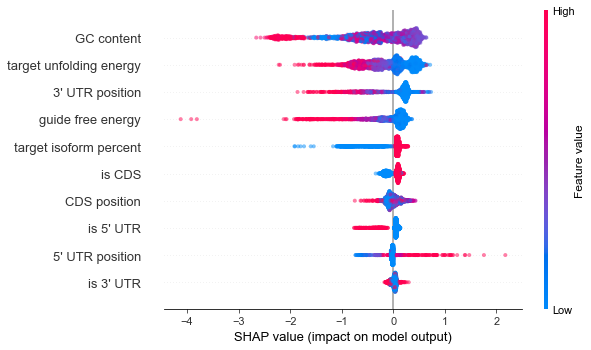

In [12]:
# summarize the effects of all the features
#secondary features
shap.plots.beeswarm(shap_values[:,-10:],alpha=0.5,show=False)
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.savefig('../../../a_figures/linearmodel_shap_beeswarm_full.svg')

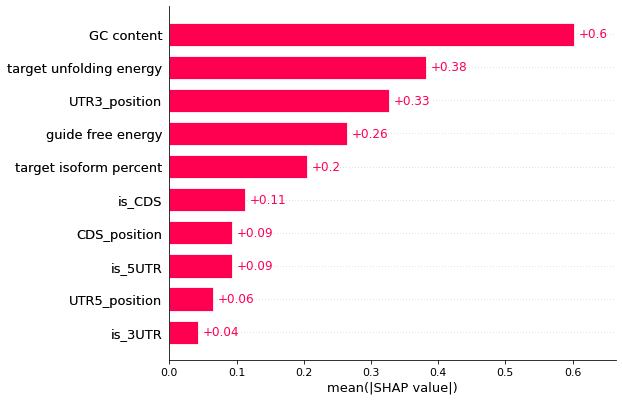

In [18]:
#mean and sd - the mean absolute value of the SHAP values for each feature
plt.clf()
shap.plots.bar(shap_values[:,-10:],show=False)
#plt.savefig('a_figures/linearmodel_shap_features_bar2.svg')

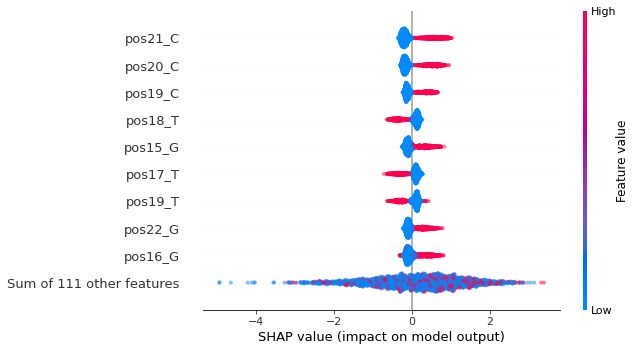

In [18]:
#seq
plt.clf()
shap.plots.beeswarm(shap_values[:,:-10],alpha=0.5,show=False)
#plt.savefig('a_figures/linearmodel_shap_seq_beeswarm2.svg')

<Figure size 432x288 with 0 Axes>

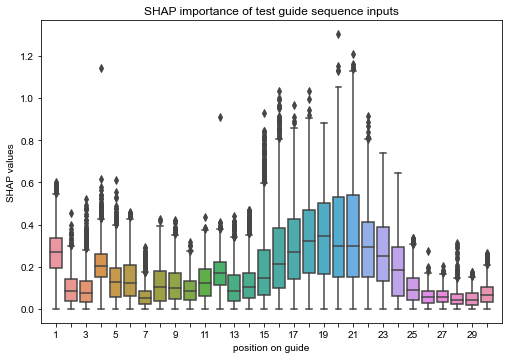

In [14]:
#position importance
plt.clf()
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1,0.2,0.8,0.7])

pos_shap = []
for p in range(30):
    df_shap[str(p+1)] = df_shap.iloc[:, 4*p:(4*p+4)].sum(axis=1)
    
pos_label = [str(p+1) for p in range(30)]
ax = sns.boxplot(data=df_shap[pos_label].abs()) 
ax.set_xlim(-1,30)
ax.set_title("SHAP importance of test guide sequence inputs")
ax.set_xlabel('position on guide')
ax.set_ylabel('SHAP values')
#ax.tick_params(axis='x', which='major', labelsize=10)
#ax.tick_params(axis='x', which='minor', labelsize=8)
#ax.legend()
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.savefig('../../../a_figures/gradient_boosting_shap_position.svg')

<Figure size 432x288 with 0 Axes>

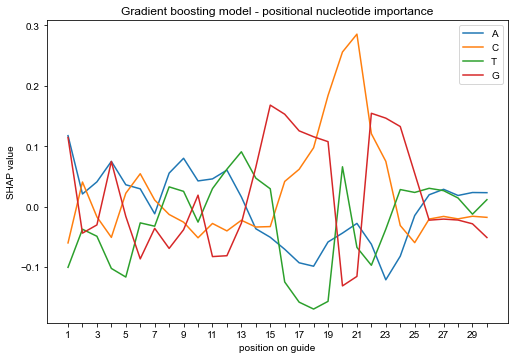

In [20]:
#positional nucleotide importance
nuc_shap = {} #key is nuc, value is list of shap values at each pos
for p in range(1,31):
    for bi in range(4):
        base = base_positions[bi]
        shap_l = 'pos'+str(p)+'_'+ base +'_shapvalue'
        nuc_label = 'pos'+str(p)+'_'+ base
        shapv = np.mean(np.abs(df_shap[shap_l].values))
        shapv_nonzero = np.multiply(df_shap[shap_l].values,df_shap[nuc_label].values)
        shapv_nonzero_mean =  np.mean(shapv_nonzero[shapv_nonzero != 0])
        if shapv_nonzero_mean<0:
            shapv= -shapv
        #maxi =np.where(np.abs(df_shap[shap_l].values)==max(np.abs(df_shap[shap_l].values)))
        #if df_shap[shap_l].values[maxi]< 0:
        #    shapv=-shapv
        if base in nuc_shap.keys():
            nuc_shap[base].append(shapv)
        else:
            nuc_shap[base] = [shapv]
plt.clf()          
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1,0.2,0.8,0.7])
x1 = np.arange(1,31)
ax.set_xticks(x1)
base_list = ['A','C','T','G']
for base in base_list:
    ax.plot(x1, nuc_shap[base], label=base)
ax.set_title("Gradient boosting model - positional nucleotide importance")
ax.set_xlabel('position on guide')
#ax.set_xticklabels(sample1_labels)
ax.set_ylabel('SHAP value')
#ax.tick_params(axis='x', which='major', labelsize=10)
#ax.tick_params(axis='x', which='minor', labelsize=8)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.legend()
plt.savefig('../../../a_figures/gradient_boosting_shap_nucleotide.svg')